In [14]:
import pandas as pd

df = pd.read_csv("AirQuality_cleaned.csv")

# Fix time format (18.00.00 → 18:00:00)
df['Time'] = df['Time'].str.replace('.', ':', regex=False)



In [15]:
df['DateTime'] = pd.to_datetime(
    df['Date'] + ' ' + df['Time'],
    dayfirst=True
)


In [16]:
df = df.drop(['Date', 'Time'], axis=1)



In [17]:
df = df.set_index('DateTime')


In [18]:
df.index.dtype


dtype('<M8[ns]')

In [19]:
df.columns


Index(['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
       'T', 'RH', 'AH'],
      dtype='object')

In [20]:
corr = df.corr()

# Sort correlation with respect to target
corr['CO(GT)'].sort_values(ascending=False)


CO(GT)           1.000000
NO2(GT)          0.672096
NOx(GT)          0.527421
NMHC(GT)         0.126467
PT08.S5(O3)      0.078184
PT08.S1(CO)      0.041732
PT08.S2(NMHC)    0.032357
C6H6(GT)        -0.029960
AH              -0.044761
RH              -0.050986
T               -0.066331
PT08.S4(NO2)    -0.076648
PT08.S3(NOx)    -0.092224
Name: CO(GT), dtype: float64

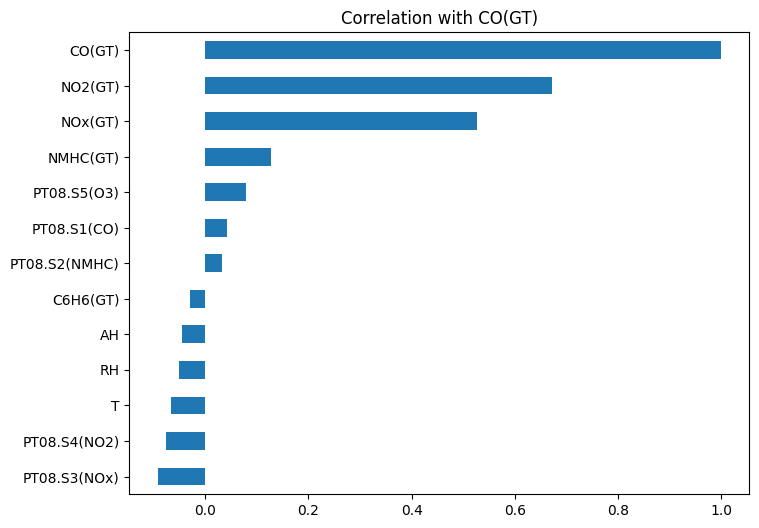

In [21]:
import matplotlib.pyplot as plt

corr['CO(GT)'].sort_values().plot(kind='barh', figsize=(8,6))
plt.title("Correlation with CO(GT)")
plt.show()

In [22]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print("Training size:", X_train.shape)
print("Testing size:", X_test.shape)


NameError: name 'X' is not defined

In [12]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)

print("Linear Regression MSE:", mse_lr)
print("Linear Regression MAE:", mae_lr)


NameError: name 'X_train' is not defined

In [ ]:
rf = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print("Random Forest MSE:", mse_rf)
print("Random Forest MAE:", mae_rf)


In [ ]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest"],
    "MSE": [mse_lr, mse_rf],
    "MAE": [mae_lr, mae_rf]
})

results


In [ ]:
features = ['NO2(GT)', 'NOx(GT)']
target = 'CO(GT)'

X = df[features]
y = df[target]


In [ ]:
comparison = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest"],
    "RMSE": [rmse_lr, rmse_rf],
    "MAE": [mae_lr, mae_rf]
})

comparison


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
print(X_scaled.shape)
print(y_scaled.shape)


In [ ]:
import numpy as np

def create_sequences(X, y, time_steps=24):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)


In [ ]:
TIME_STEPS = 24  # 24 hours

X_lstm, y_lstm = create_sequences(X_scaled, y_scaled, TIME_STEPS)

print(X_lstm.shape)
print(y_lstm.shape)


In [ ]:
split = int(0.8 * len(X_lstm))

X_train, X_test = X_lstm[:split], X_lstm[split:]
y_train, y_test = y_lstm[:split], y_lstm[split:]

print(X_train.shape, X_test.shape)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

model.summary()


In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1
)


In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("LSTM Training Loss")
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred_lstm = model.predict(X_test)

# Inverse scaling
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred_lstm)

mse_lstm = mean_squared_error(y_test_inv, y_pred_inv)
mae_lstm = mean_absolute_error(y_test_inv, y_pred_inv)

print("LSTM MSE:", mse_lstm)
print("LSTM MAE:", mae_lstm)


In [ ]:
results.loc[len(results)] = ["LSTM", mse_lstm, mae_lstm]
results


In [ ]:
import matplotlib.pyplot as plt

results.set_index("Model")[["MSE", "MAE"]].plot(kind="bar", figsize=(8,5))
plt.title("Model Comparison (Lower is Better)")
plt.ylabel("Error")
plt.xticks(rotation=0)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# MSE plot
plt.figure(figsize=(6,4))
plt.bar(results["Model"], results["MSE"])
plt.title("Model Comparison using MSE (Lower is Better)")
plt.ylabel("MSE")
plt.show()

# MAE plot
plt.figure(figsize=(6,4))
plt.bar(results["Model"], results["MAE"])
plt.title("Model Comparison using MAE (Lower is Better)")
plt.ylabel("MAE")
plt.show()


In [ ]:
model.save("lstm_air_quality_model.h5")


In [ ]:
import joblib
joblib.dump(scaler_X, "scaler_X.pkl")
joblib.dump(scaler_y, "scaler_y.pkl")


In [ ]:
pip install ipykernel


In [ ]:
from tensorflow.keras.models import load_model

model.save(
    "lstm_air_quality_model_fixed.keras",
    save_format="keras"
)


In [ ]:
# Re-save model WITHOUT batch_shape issues
model.save("lstm_air_quality_model_fixed.keras")


In [ ]:
from tensorflow.keras.models import load_model
model = load_model("lstm_air_quality_model_fixed.keras", compile=False)
